In [1]:
# Import necessary libraries
import datetime as dt
import os
import warnings
from collections import UserDict
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common.utils import load_data, mape
from IPython.display import Image
%matplotlib inline
pd.options.display.float_format = "{:,.2f}".format
os.chdir("../../")
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")
data_dir = "data"
# Load the data from csv into a pandas dataframe
ts_data_load = load_data(data_dir)[['load']]
ts_data_load.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

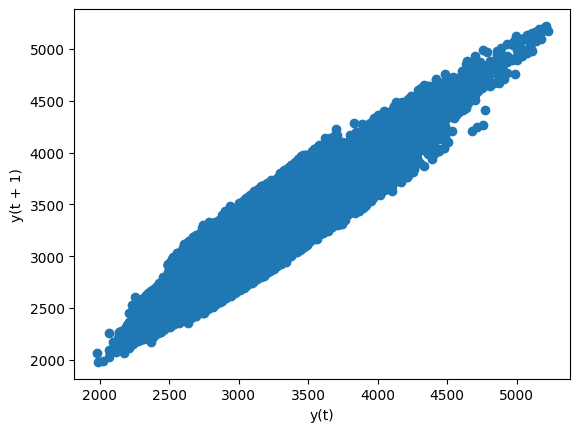

In [2]:
from pandas.plotting import lag_plot

plt.figure()

# Pass the lag argument and plot the values. 
# When lag=1 the plot is essentially data[:-1] vs. data[1:]
# Plot our ts_data_load set
lag_plot(ts_data_load)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

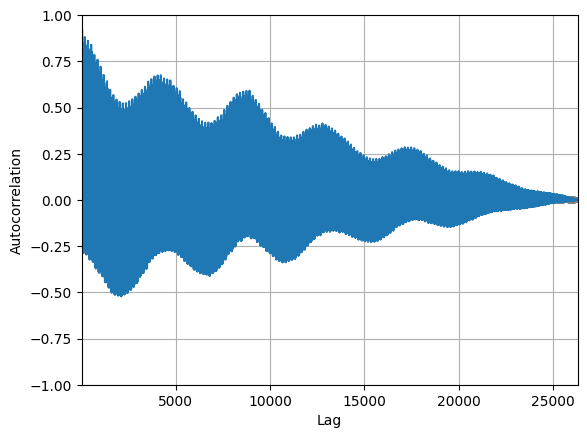

In [3]:
# Import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(ts_data_load)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

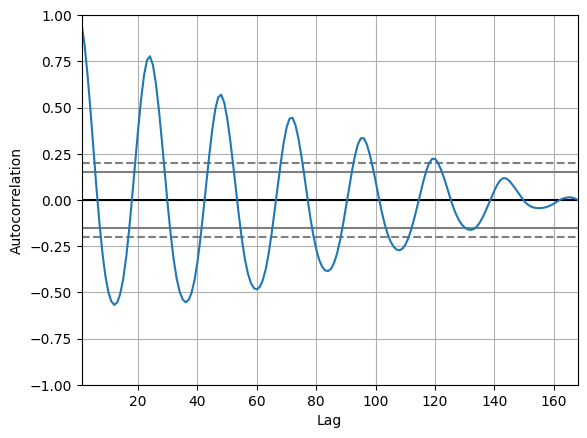

In [4]:
# Create subset
ts_data_load_subset = ts_data_load['2014-08-01':'2014-08-07']
# Import autocorrelation _plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
# Pass the autocorrelation argument and plot the values 
autocorrelation_plot(ts_data_load_subset)

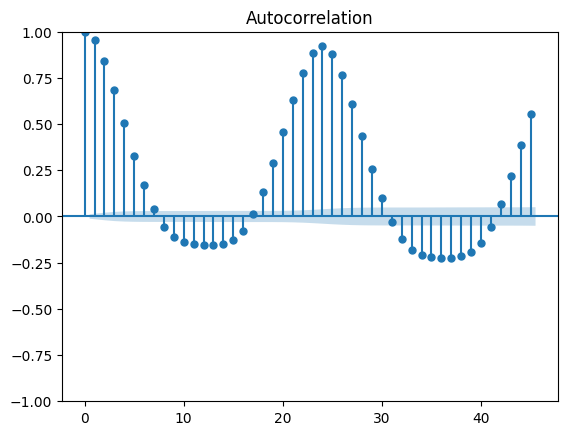

In [5]:
from matplotlib import pyplot
# Import plot_acf() function 
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load set
plot_acf(ts_data_load)
pyplot.show()

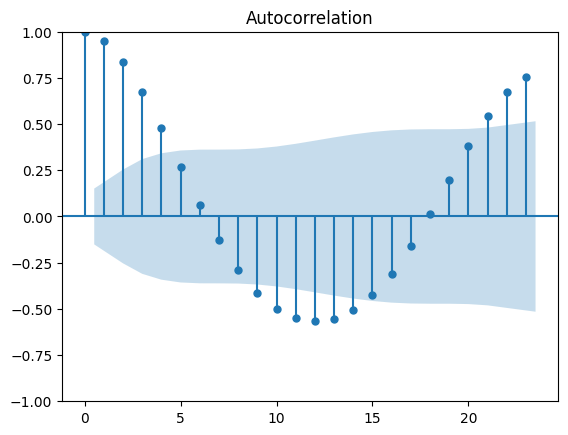

In [6]:
# Import plot_acf() function
from statsmodels.graphics.tsaplots import plot_acf
# Plot the acf function on the ts_data_load_subset
plot_acf(ts_data_load_subset)
pyplot.show()

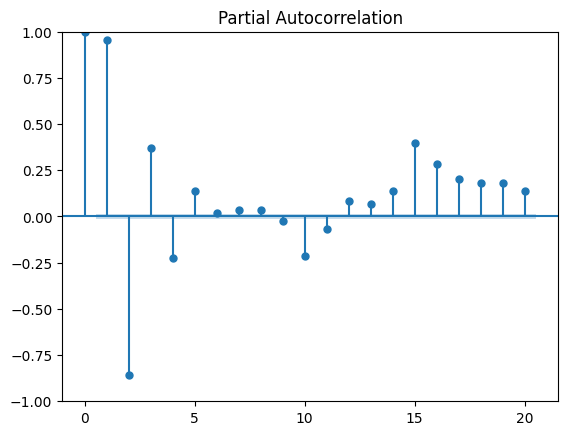

In [7]:
# Import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# Plot the pacf function on the ts_data_load dataset
plot_pacf(ts_data_load, lags=20)
pyplot.show()

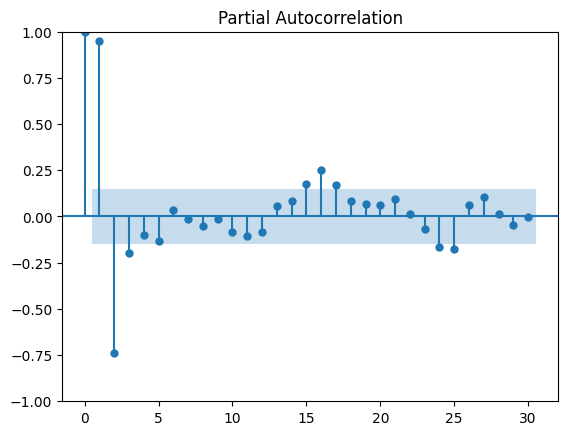

In [8]:
# import plot_pacf() function
from statsmodels.graphics.tsaplots import plot_pacf
# plot the pacf function on the ts_data_load_subset
plot_pacf(ts_data_load_subset, lags=30)
pyplot.show() 


In [13]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
# Apply AutoReg model
model = AutoReg(ts_data_load, 1)
results = model.fit()
results.summary()
print(results.summary())

                            AutoReg Model Results                             
Dep. Variable:                   load   No. Observations:                26304
Model:                     AutoReg(1)   Log Likelihood             -171639.978
Method:               Conditional MLE   S.D. of innovations            165.100
Date:                Tue, 14 Nov 2023   AIC                         343285.956
Time:                        16:27:44   BIC                         343310.488
Sample:                    01-01-2012   HQIC                        343293.877
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.5181      6.043     23.913      0.000     132.673     156.363
load.L1        0.9563      0.002    530.344      0.000       0.953       0.960
                                    Roots           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


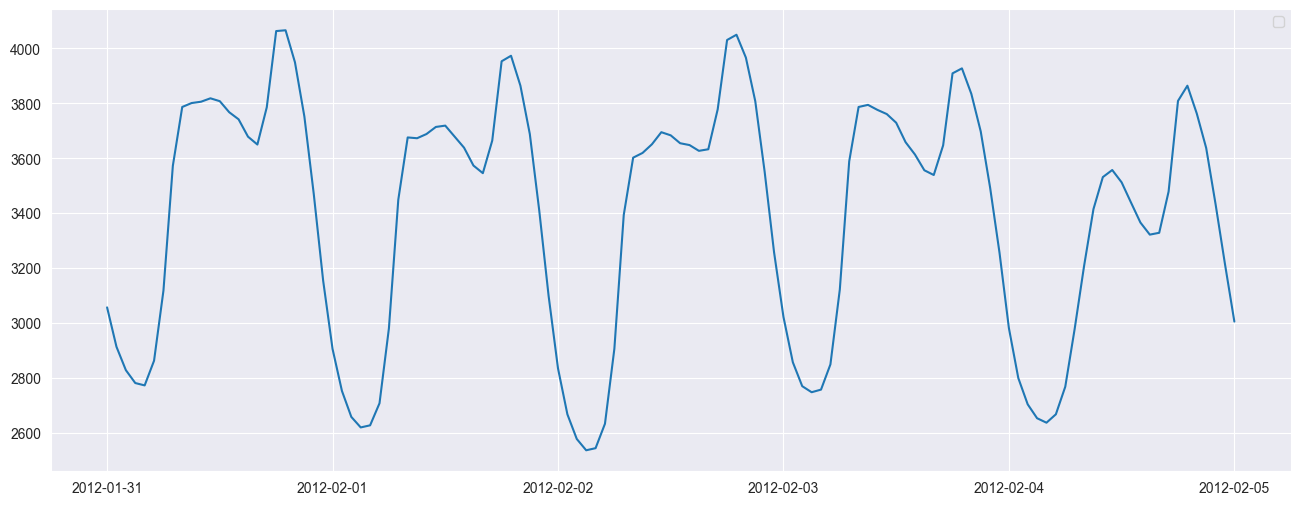

In [14]:
# Define figure style, plot package and default figure size
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
# Use plot_predict and visualize forecasts
figure = results.plot_predict(720, 840)

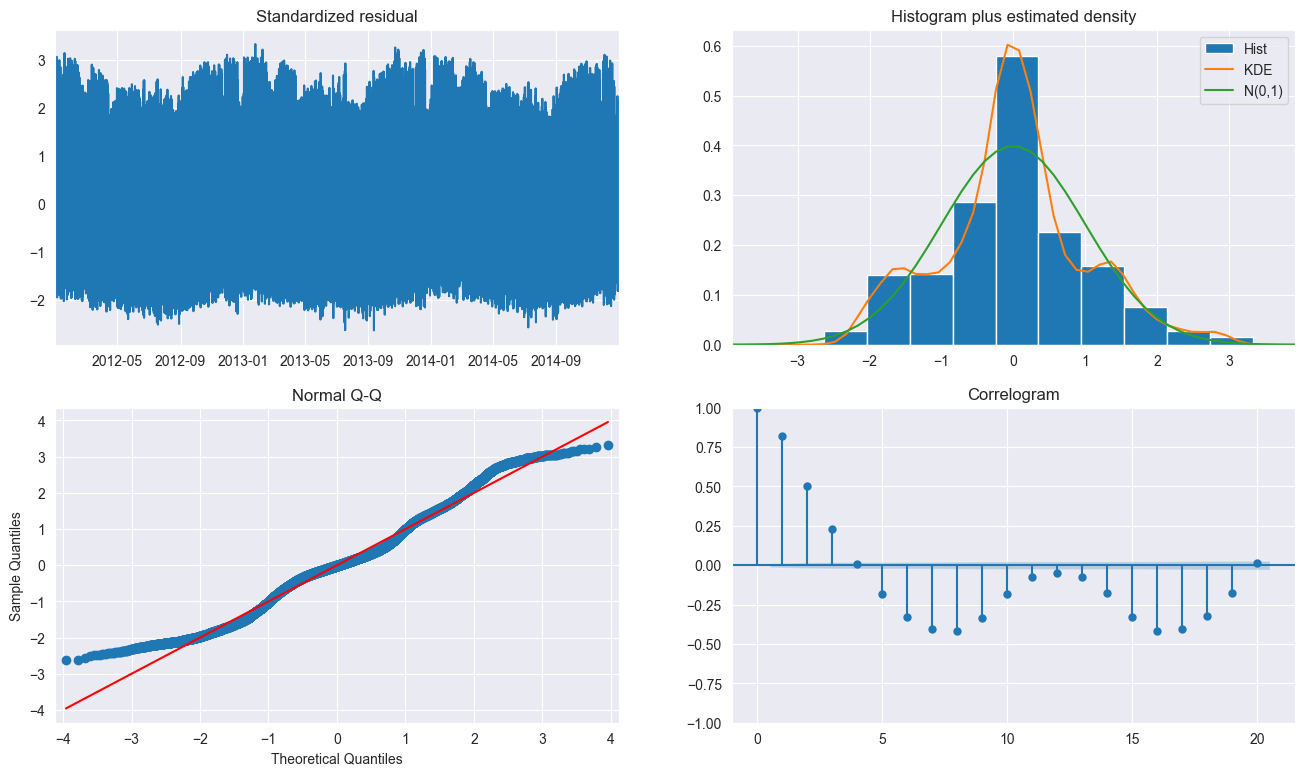

In [16]:
# Define default figure size
fig = plt.figure(figsize=(16,9))
# Use plot_predict and visualize forecasts
fig = results.plot_diagnostics(fig=fig, lags=20)

In [17]:
# Define the start date for the train and test sets
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

In [22]:
# Create train set containing only the model features
ts_data_load2 = ts_data_load.copy(deep=True)
# ts_data_load2 = ts_data_load2.asfreq(1, )
train = ts_data_load2.copy()[(ts_data_load.index >= train_start_dt) & (ts_data_load.index < test_start_dt)][['load']]
test = ts_data_load2.copy()[ts_data_load.index >= test_start_dt][['load']]
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

# Scale train data to be in range (0, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head()
# Scale test data to be in range (0, 1)
test['load'] = scaler.transform(test)
test.head()

# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Training data shape:  (1416, 1)
Test data shape:  (48, 1)
Forecasting horizon: 3 hours


In [23]:
# Create a test data point for each HORIZON 
test_shifted = test.copy()
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2
2014-12-30 00:00:00,0.33,0.29,0.27
2014-12-30 01:00:00,0.29,0.27,0.27
2014-12-30 02:00:00,0.27,0.27,0.30
2014-12-30 03:00:00,0.27,0.30,0.41
2014-12-30 04:00:00,0.30,0.41,0.57


In [26]:
%%time
# Make predictions on the test data
training_window = 720
train_ts = train['load']
test_ts = test_shifted
history = [x for x in train_ts]

history

CPU times: total: 0 ns
Wall time: 0 ns


[0.10161145926589077,
 0.06580125335720677,
 0.04610564010743046,
 0.04252461951656206,
 0.05908683974932849,
 0.1042972247090419,
 0.19113697403760055,
 0.30572963294538935,
 0.4037600716204117,
 0.4785138764547896,
 0.5143240823634734,
 0.5268576544315129,
 0.5156669650850492,
 0.5013428827215756,
 0.4932855863921217,
 0.49910474485228273,
 0.5384959713518351,
 0.5948970456580125,
 0.6042972247090419,
 0.5447627573858549,
 0.4874664279319605,
 0.3965980304386749,
 0.2882721575649059,
 0.18621307072515658,
 0.12488809310653526,
 0.07251566696508505,
 0.05550581915846009,
 0.05595344673231861,
 0.07743957027752901,
 0.13115487914055501,
 0.23142345568487,
 0.35452103849597116,
 0.4713518352730528,
 0.5344673231871082,
 0.5626678603401969,
 0.5738585496866606,
 0.5523724261414502,
 0.5232766338406445,
 0.49955237242614126,
 0.5085049239033124,
 0.5671441360787823,
 0.6347358997314234,
 0.5989256938227394,
 0.5219337511190689,
 0.45792300805729624,
 0.3464637421665173,
 0.226051924798567

In [27]:
history = history[(-training_window):]
history

[0.2708146821844224,
 0.22112802148612354,
 0.1866606982990151,
 0.16920322291853163,
 0.17502238137869286,
 0.20904207699194255,
 0.2569382273948073,
 0.3455684870188003,
 0.4610564010743061,
 0.5402864816472694,
 0.5675917636526409,
 0.5716204118173678,
 0.5514771709937332,
 0.5273052820053714,
 0.5174574753804833,
 0.554610564010743,
 0.684870188003581,
 0.7287376902417189,
 0.6965085049239033,
 0.6351835273052819,
 0.55863921217547,
 0.4288272157564905,
 0.29856759176365255,
 0.19516562220232747,
 0.13115487914055501,
 0.09758281110116362,
 0.08728737690241717,
 0.08728737690241717,
 0.13384064458370615,
 0.2578334825425246,
 0.4677708146821844,
 0.5599820948970455,
 0.5729632945389436,
 0.5734109221128021,
 0.5962399283795881,
 0.582363473589973,
 0.5702775290957922,
 0.5720680393912263,
 0.5671441360787823,
 0.58325872873769,
 0.7050134288272156,
 0.797224709042077,
 0.7936436884512086,
 0.748433303491495,
 0.690689346463742,
 0.5702775290957922,
 0.434198746642793,
 0.3240823634

In [63]:
predictions = list()

out = {
    "time": [],
    "1hr predicted": [],
    "1hr Expected": [],
    "2hr predicted": [],
    "2hr Expected": [],
    "3hr predicted": [],
    "3hr Expected": [],
}

for t in range(test_ts.shape[0]):
    model = AutoReg(history, 1)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t + 1, ": predicted =", yhat, "expected =", obs)
    
    print(obs[0])
    content = [
        test_ts.index[t],
        yhat[0],
        obs[0],
        yhat[1],
        obs[1],
        yhat[2],
        obs[2],
    ]
    out["time"].append(test_ts.index[t])
    out["1hr predicted"].append(yhat[0])
    out["1hr Expected"].append(obs[0])
    out["2hr predicted"].append(yhat[1])
    out["2hr Expected"].append(obs[1])
    out["3hr predicted"].append(yhat[2])
    out["3hr Expected"].append(obs[2])
    

2014-12-30 00:00:00
1 : predicted = [0.62 0.62 0.62] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
0.32945389435989236
2014-12-30 01:00:00
2 : predicted = [0.35 0.38 0.4 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
0.2900626678603402
2014-12-30 02:00:00
3 : predicted = [0.32 0.34 0.37] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
0.2739480752014323
2014-12-30 03:00:00
4 : predicted = [0.3  0.33 0.36] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
0.26812891674127126
2014-12-30 04:00:00
5 : predicted = [0.3  0.33 0.35] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
0.3025962399283795
2014-12-30 05:00:00
6 : predicted = [0.33 0.35 0.38] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
0.40823634735899716
2014-12-30 06:00:00
7 : predicted = [0.43 0.44 0.46] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
0

In [ ]:
# attempt to get difference over time

In [67]:
df = pd.DataFrame(out)
df.set_index("time", inplace=True)
df

,1hr predicted,1hr Expected,2hr predicted,2hr Expected,3hr predicted,3hr Expected
time,,,,,,
2014-12-30 00:00:00,0.62,0.33,0.62,0.29,0.62,0.27
2014-12-30 01:00:00,0.35,0.29,0.38,0.27,0.40,0.27
2014-12-30 02:00:00,0.32,0.27,0.34,0.27,0.37,0.30
2014-12-30 03:00:00,0.30,0.27,0.33,0.30,0.36,0.41
2014-12-30 04:00:00,0.30,0.30,0.33,0.41,0.35,0.57
2014-12-30 05:00:00,0.33,0.41,0.35,0.57,0.38,0.68
2014-12-30 06:00:00,0.43,0.57,0.44,0.68,0.46,0.73
2014-12-30 07:00:00,0.58,0.68,0.58,0.73,0.59,0.75
2014-12-30 08:00:00,0.68,0.73,0.67,0.75,0.67,0.76


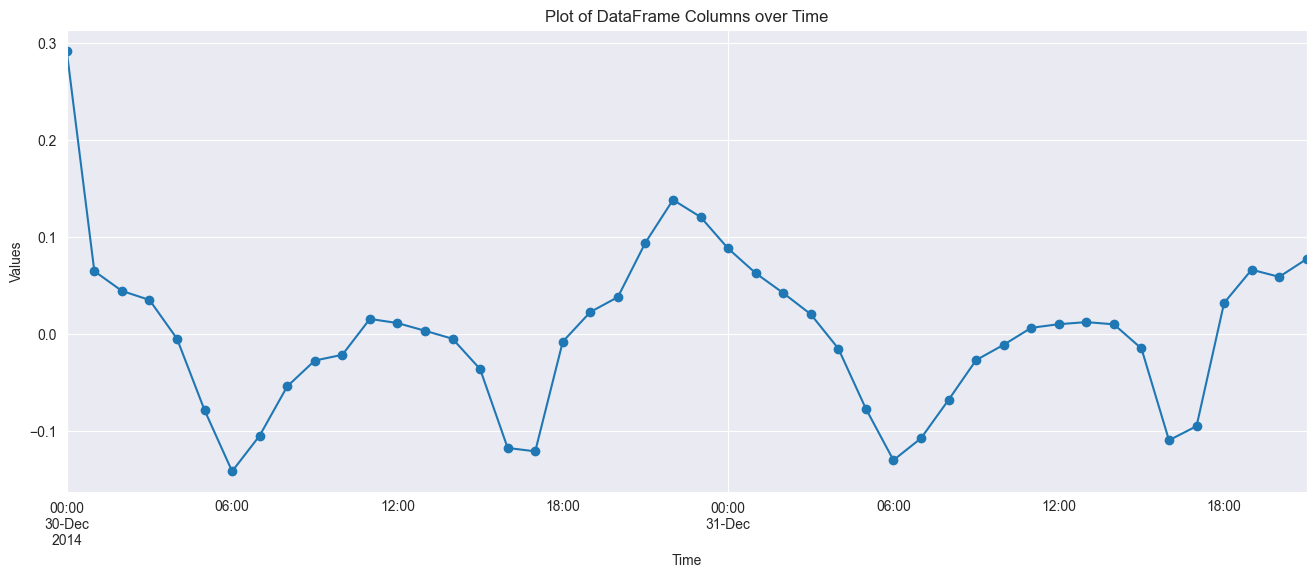

In [70]:
count = 1
predicted = f"{count}hr predicted"
expected = f"{count}hr Expected"
count = f'diff{count}'
df[count] = df[predicted] - df[expected]
one = df[count]
one.plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plot of DataFrame Columns over Time')
plt.show()

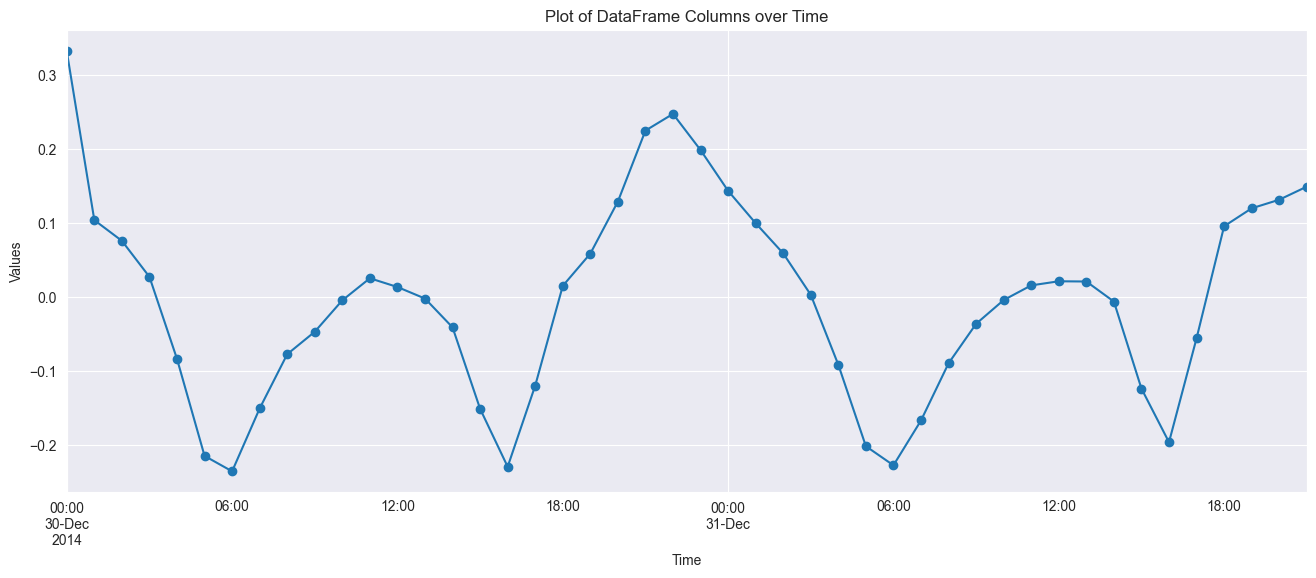

In [71]:
count = 2
predicted = f"{count}hr predicted"
expected = f"{count}hr Expected"
count = f'diff{count}'
df[count] = df[predicted] - df[expected]
one = df[count]
one.plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plot of DataFrame Columns over Time')
plt.show()

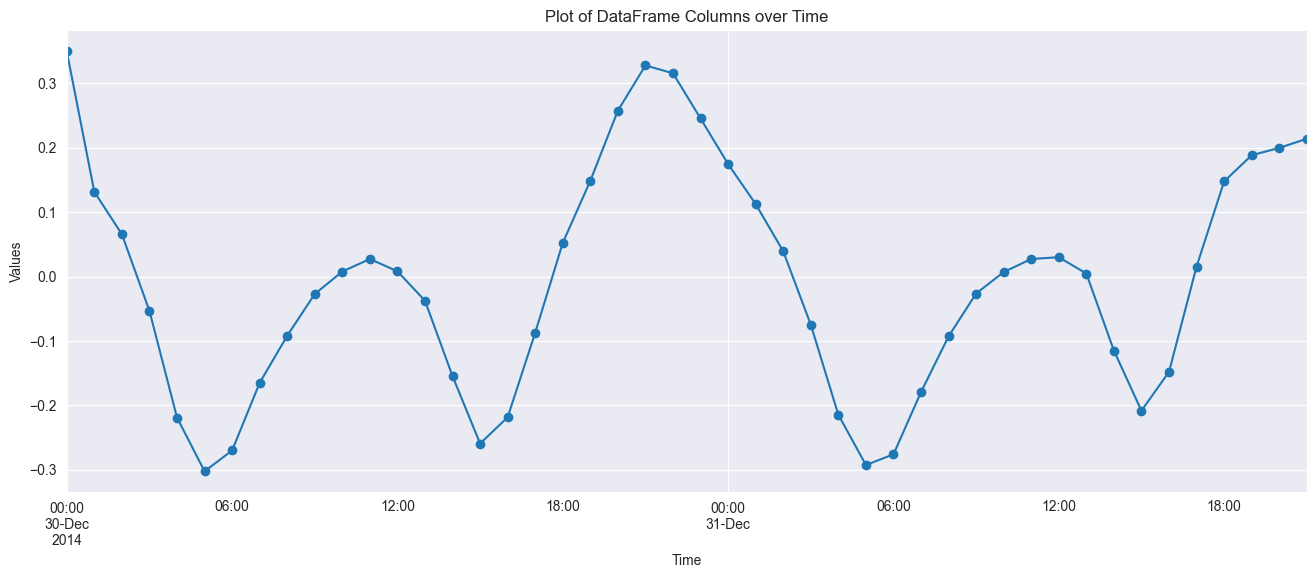

In [72]:
count = 3
predicted = f"{count}hr predicted"
expected = f"{count}hr Expected"
count = f'diff{count}'
df[count] = df[predicted] - df[expected]
one = df[count]
one.plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plot of DataFrame Columns over Time')
plt.show()